In [1]:
#imports
import random as rd
from PIL import Image
from PIL import ImageColor
import numpy as np
import matplotlib.pyplot as plt
import random
from dtw import DTWDistance
import os

### Data generation

In [2]:
# This is the code for the random urban area generation
class map_maker:
    def __init__(self, size, sub_areas, noise_strength, wrong_patterns, wrong_patterns_strength):
        self.size = size
        self.noise_map = self.generate_noise(self.size,self.size)

        #strength of the noise used in the asignment of patterns
        self.noise_strength = noise_strength 

        # whether or not the wrong pattern noise should be used
        self.wrong_patterns = wrong_patterns
        self.wrong_patterns_strength = wrong_patterns_strength

        # amount of functional areas we want
        # thus equal to the amount of classes
        self.sub_areas = sub_areas

        # list with the class names
        self.sub_area_classes = [i for i in range(sub_areas)]

        # map with class for every building
        self.area_map = self.assign_class()

        # list which contains temporal pattern for every "building"
        self.pattern_map = self.fill_pattern_map()

        # dict with as key coordinates and as values the rgb color tuple
        self.color_map = self.create_color_map()



    def generate_noise(self, width, height):
        noise_map = []
        # Populate a noise map with 0s
        for y in range(height):
            new_row = []
            for x in range(width):
                new_row.append(0)
            noise_map.append(new_row)

        # Progressively apply variation to the noise map but changing values + or -
        # 5 from the previous entry in the same list, or the average of the
        # previous entry and the entry directly above
        new_value = 0
        top_of_range = 0
        bottom_of_range = 0
        for y in range(height):
            for x in range(width):
                if x == 0 and y == 0:
                    continue
                if y == 0:  # If the current position is in the first row
                    new_value = noise_map[y][x - 1] + rd.randint(-1000, +1000)
                elif x == 0:  # If the current position is in the first column
                    new_value = noise_map[y - 1][x] + rd.randint(-1000, +1000)
                else:
                    minimum = min(noise_map[y][x - 1], noise_map[y-1][x])
                    maximum = max(noise_map[y][x - 1], noise_map[y-1][x])
                    average_value = minimum + ((maximum-minimum)/2.0)
                    new_value = average_value + rd.randint(-1000, +1000)
                noise_map[y][x] = new_value
                # check whether value of current position is new top or bottom
                # of range
                if new_value < bottom_of_range:
                    bottom_of_range = new_value
                elif new_value > top_of_range:
                    top_of_range = new_value
        # Normalises the range, making minimum = 0 and maximum = 1
        difference = float(top_of_range - bottom_of_range)
        for y in range(height):
            for x in range(width):
                noise_map[y][x] = (noise_map[y][x] - bottom_of_range)/difference
        return noise_map


    # creates a color map based on the classes
    def create_color_map(self):
        noise_map = self.noise_map
        color_map = {}
        for i in range(len(noise_map)):
            for j in range(len(noise_map[i])):
                # area 1
                if self.area_map[i][j] == 0:
                    color = tuple([204,102,0])
                #area 2
                elif self.area_map[i][j] == 1:
                    color = tuple([153, 51, 255])
                else:
                    color = tuple([0,153,76])
                color_map[tuple([i,j])] = color
        return color_map


    # assigns a class to every value of the noise map
    # the amount of classes is determined by the initialization
    def assign_class(self):
        area_map = [[] for i in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                area_map[i].append(0)

        #creates the boundaries for the sub areas
        boundaries = np.linspace(0,1, self.sub_areas + 1)

        # create bins where the values are [lower_bound, upperbound)
        # thus the lower_bound belongs to the bin but the upper bound does not
        bins = []
        for i in range(self.sub_areas):
            bins.append((boundaries[i], boundaries[i+1]))

        #iterate over every "building" in the map and assign a class
        for i in range(len(self.noise_map)):
            for j in range(len(self.noise_map[i])):
                for bin_number in range(len(bins)):
                    if self.noise_map[i][j] >= bins[bin_number][0] and self.noise_map[i][j] < bins[bin_number][1]:
                        area_map[i][j] = bin_number

                    # since the upperbound is not included, we need an edge case for the last upperbound (which is 1)
                    # we assign the last class to thiss area
                    if self.noise_map[i][j] == bins[self.sub_areas - 1][1]:
                        area_map[i][j] = self.sub_areas - 1

        
        return area_map

    def fill_pattern_map(self):
        pattern_map = [[] for i in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                pattern_map[i].append([])

        #iterate over every "building" in the map and assign a class
        for i in range(len(self.area_map)):
            for j in range(len(self.area_map[i])):
                current_class = self.area_map[i][j]
                if self.wrong_patterns:
                    chance =np.random.rand()
                    if chance < self.wrong_patterns_strength:
                        if current_class == 0:
                            current_class = random.choice([1,2])
                        elif current_class == 1:
                            current_class = random.choice([0,2])
                        elif current_class == 2:
                            current_class = random.choice([0,1])

                pattern = self.assign_pattern(noise_strength=self.noise_strength, current_class=current_class)
                pattern_map[i][j] = pattern


        return pattern_map
       

    def assign_pattern(self, noise_strength=0, current_class=0):
        # supply 168 time points (represents one week)
        time_points = np.arange(0,168,1)

        # adjust the time points to radians for the sin function
        time_points_2 = time_points * ((2 * np.pi)/24)

        # create three types of standardized data
        if current_class == 0:
            # create points such that the shape resembles the original paper
            # we found that for the residential area, the maximum is around 50
            temp = 100 * np.sin(time_points_2 - (9 * ( np.pi/12)))
            temp_2 = 100 * np.sin(time_points_2 - (17 * ( np.pi/12)))

        if current_class == 1:
            # create points such that the shape resembles the original paper
            # we found that for the residential area, the maximum is around 50
            temp = 120 * np.sin(time_points_2 - (9 * ( np.pi/12)))
            temp_2 = 120 * np.sin(time_points_2 - (17 * ( np.pi/12)))

        if current_class == 2:
            # create points such that the shape resembles the original paper
            # we found that for the residential area, the maximum is around 50
            temp = 140 * np.sin(time_points_2 - (9 * ( np.pi/12)))
            temp_2 = 140 * np.sin(time_points_2 - (17 * ( np.pi/12)))

        # make sure that all values are above 0
        temp = np.where(temp < 0, 0, temp)
        temp_2 = np.where(temp_2 < 0, 0, temp_2)

        # the original data will be the mean of the previous two
        temp_3 = [np.mean([temp[i], temp_2[i]]) for i in range(len(temp))]

        # add the strength of our noise we want
        noise = np.random.normal(0,noise_strength,len(time_points))
        temp_4 = temp_3 + noise

        # again make sure that the value is never lower than 0
        temp_4 = np.where(temp_4 < 0, 0, temp_4)
        
        return temp_4


    def save_map(self, name):
        background = (0, 0, 0, 255)
        im = Image.new("RGB", (self.size,self.size), background)
        pixels = im.load()
        for i in range(len(self.noise_map)):
            for j in range(len(self.noise_map[i])):
                pixels[i,j] = self.color_map[tuple([i,j])]
        im.save(name + ".png", "PNG")




# # size 100, 3 sub areas, 0 noise, no wrong patterns, no wrong pattern strength
# newmap = map_maker(10, 3, 0, False, 0.0)

#print(newmap.area_map)

In [3]:
def get_1_list(ori_list):
    list=[]
    for i in range(len(ori_list)):
        for j in range(len(ori_list[i])):
            if type(ori_list[i][j]) is int:
                list.append(ori_list[i][j])
            else:
                list.append(ori_list[i][j].tolist())
    return list


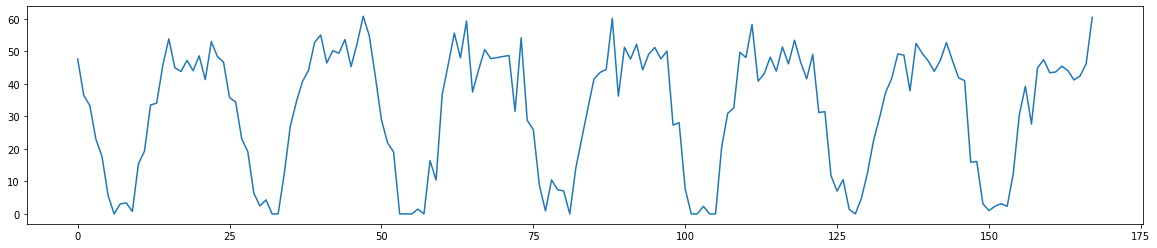

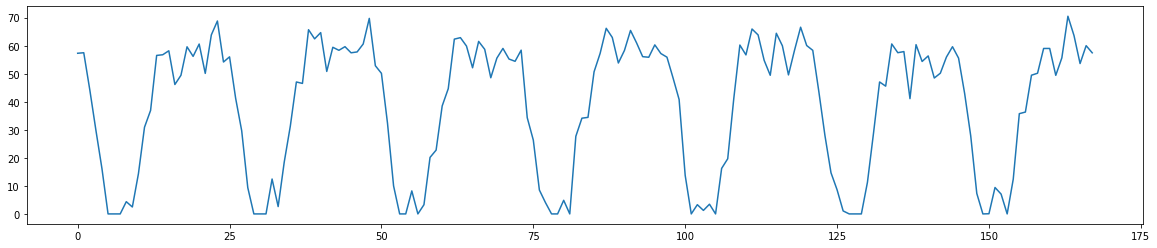

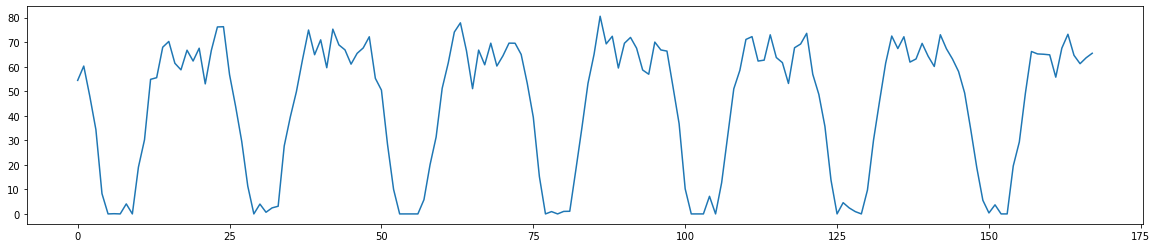

In [4]:
# the code to generate the spacial temporal patterns
import numpy as np
import matplotlib.pyplot as plt


# supply 168 time points (represents one week)
time_points = np.arange(0,168,1)

# adjust the time points to radians for the sin function
time_points_2 = time_points * ((2 * np.pi)/24)


current_class = 0

noise_strength = 5

# create three types of standardized data
if current_class == 0:
    x = 1

    # create points such that the shape resembles the original paper
    # we found that for the residential area, the maximum is around 50
    temp = 100 * np.sin(time_points_2 - (9 * ( np.pi/12)))
    temp_2 = 100 * np.sin(time_points_2 - (17 * ( np.pi/12)))


    # make sure that all values are above 0
    temp = np.where(temp < 0, 0, temp)
    temp_2 = np.where(temp_2 < 0, 0, temp_2)

    # the original data will be the mean of the previous two
    temp_3 = [np.mean([temp[i], temp_2[i]]) for i in range(len(temp))]

    # add the strength of our noise we want
    noise = np.random.normal(0,noise_strength,len(time_points))
    temp_4 = temp_3 + noise

    # again make sure that the value is never lower than 0
    temp_4 = np.where(temp_4 < 0, 0, temp_4)

   

    #temp_3 = np.array(temp_3)
    #print(temp_3.shape)

    f  = plt.figure()
    f.set_figwidth(20)

    #plt.plot(time_points, temp)
    #plt.plot(time_points, temp_2)
    #plt.plot(time_points, temp_3)
    plt.plot(time_points, temp_4)
    plt.show()

current_class = 1
if current_class == 1:
    # create points such that the shape resembles the original paper
    # we found that for the residential area, the maximum is around 50
    temp = 120 * np.sin(time_points_2 - (9 * ( np.pi/12)))
    temp_2 = 120 * np.sin(time_points_2 - (17 * ( np.pi/12)))


    # make sure that all values are above 0
    temp = np.where(temp < 0, 0, temp)
    temp_2 = np.where(temp_2 < 0, 0, temp_2)

    # the original data will be the mean of the previous two
    temp_3 = [np.mean([temp[i], temp_2[i]]) for i in range(len(temp))]

    # add the strength of our noise we want
    noise = np.random.normal(0,noise_strength,len(time_points))
    temp_4 = temp_3 + noise

    # again make sure that the value is never lower than 0
    temp_4 = np.where(temp_4 < 0, 0, temp_4)

   

    #temp_3 = np.array(temp_3)
    #print(temp_3.shape)

    f  = plt.figure()
    f.set_figwidth(20)

    #plt.plot(time_points, temp)
    #plt.plot(time_points, temp_2)
    #plt.plot(time_points, temp_3)
    plt.plot(time_points, temp_4)
    plt.show()

current_class = 2
if current_class == 2:
    # create points such that the shape resembles the original paper
    # we found that for the residential area, the maximum is around 50
    temp = 140 * np.sin(time_points_2 - (9 * ( np.pi/12)))
    temp_2 = 140 * np.sin(time_points_2 - (17 * ( np.pi/12)))


    # make sure that all values are above 0
    temp = np.where(temp < 0, 0, temp)
    temp_2 = np.where(temp_2 < 0, 0, temp_2)

    # the original data will be the mean of the previous two
    temp_3 = [np.mean([temp[i], temp_2[i]]) for i in range(len(temp))]

    # add the strength of our noise we want
    noise = np.random.normal(0,noise_strength,len(time_points))
    temp_4 = temp_3 + noise

    # again make sure that the value is never lower than 0
    temp_4 = np.where(temp_4 < 0, 0, temp_4)

   

    #temp_3 = np.array(temp_3)
    #print(temp_3.shape)

    f  = plt.figure()
    f.set_figwidth(20)

    #plt.plot(time_points, temp)
    #plt.plot(time_points, temp_2)
    #plt.plot(time_points, temp_3)
    plt.plot(time_points, temp_4)
    plt.show()



### Get clusters and evaluate

In [5]:
def argmin(list):
    #get min index from a list
    return list.index(min(list))
    
def argmax(list):
    #get max index from a list
    return list.index(max(list))

In [6]:
def del_index(list,index):
    list_new=[list[i] for i in range(len(list)) if (i not in index)]
    return list_new
    
def AP(ts):
    #AP to get the initialized center
    init_center=[]
    # for step in range(k-1):
    mean_=[]
    for i in range(len(ts)):
        sum_=0
        for j in range(len(ts)):
            sum_+=DTWDistance(ts[i],ts[j])
        mean_.append(sum_/len(ts))
    
    # if len(ts)%2==0:
    #     mean_.append(0)
    
    # a=np.median(mean_)
    # ref=mean_.index(np.median(mean_))#reference point
    ref=np.argmin(mean_)

    list_largest=[]
    for i in range(len(ts)):
        list_largest.append(DTWDistance(ts[ref],ts[i]))
    largest=argmax(list_largest)

    init_center.append(largest)

    largest_list=[]
    for i in range(len(ts)):
        if (DTWDistance(ts[largest],ts[i]))<(DTWDistance(ts[ref],ts[i])):
            largest_list.append(i)
    
    print(largest_list)
    ts_new=del_index(ts,largest_list)

    # a2=ts.index(ts_new[0])
    # init_center.append(a2)
    ###########        
    mean_=[]
    for i in range(len(ts_new)):
        sum_=0
        for j in range(len(ts_new)):
            sum_+=DTWDistance(ts_new[i],ts_new[j])
        mean_.append(sum_/len(ts_new))
    if len(ts_new)%2==0:
        mean_.append(0)
    ref=mean_.index(np.median(mean_))#reference point

#
    list_largest=[]
    for i in range(len(ts_new)):
        list_largest.append(DTWDistance(ts_new[ref],ts_new[i]))
    largest=argmax(list_largest)


    a1=ts.index(ts_new[largest])
    init_center.append(a1)

    largest_list=[]
    for i in range(len(ts_new)):
        if (DTWDistance(ts_new[largest],ts_new[i]))<(DTWDistance(ts_new[ref],ts_new[i])):
            largest_list.append(i)
    ts_new1=del_index(ts_new,largest_list)
    ###
    a2=ts.index(ts_new1[0])
    init_center.append(a2)

    print(init_center)
    return init_center

In [7]:
def empty_list(k):
    #create a empty list
    list=[]
    for i in range(k):
        list.append([])
    return list
        
def get_nearest(list,index,ts):
    #get mean DTWdistance of a list
    sum_=0
    for i in range(len(list)):
        sum_+=DTWDistance(ts[list[i]],ts[list[index]])
    return sum_/len(list)


def get_medriod(ts,k,init_list):
    #get k clusters and their medroids
    done=False
    center=[]
    center_index=init_list
    # center_index=[]
    # center_index=random.sample(range(0,len(ts)),k)
    # print(center_index)
    # for i in range(k):
    #     center.append(ts[i])
    # for i in range(k):
    #     index=random.randint(0,len(ts)-1)
    #     center.append(ts[index])
    #     center_index.append(index)
    
    # p=0

    while done==False:
        #if the center of all cluster is not change, end while
        # p+=1
        cluster_list=empty_list(k)

        center=[]
        for i in range(k):
            center.append(ts[center_index[i]])

        for i in range(len(ts)):
            # if i not in center_index:
            d=[]
            for j in range(k):
                d.append(DTWDistance(ts[i],center[j]))
            index_d=argmin(d)
            # print(center_index)
            # print(index_d)
            # print(center_index[index_d])
            # cluster_list[center_index[index_d]].append(i)
            cluster_list[index_d].append(i)
        
        center_index_new=[]

        for i in range(len(cluster_list)):
            # print(cluster_list[i])
            mean_list=[]
            for j in range(len(cluster_list[i])):
                mean_list.append(get_nearest(cluster_list[i],j,ts))#
            x=argmin(mean_list)
            center_index_new.append(cluster_list[i][x])

        center_index.sort()
        center_index_new.sort()
        if center_index_new==center_index:
            #if the center of all cluster is not change, end while
            done=True
            print(done)
        
        center_index=center_index_new
    # print('p is')
    # print(p)
    return center_index_new,cluster_list

In [15]:
# size 10, 3 sub areas, 0 noise, no wrong patterns, no wrong pattern strength
import time

start = time.time()
#newmap = map_maker(10, 3, 0, False, 0.0)

#get init_center using the same way as 
#pattern_list=get_1_list(newmap.pattern_map)
#init_center=AP(pattern_list)

#print("the init center are ",init_center)

#get the clusters and their centers
#cluster_center_final,cluster_final=get_medriod(pattern_list,3,init_center)

#end = time.time()
#dur = end-start

#print(f"with size 10 the time takes {dur} secs")

#start = time.time()
newmap = map_maker(10, 3, 0, False, 0.0)
#get init_center using the same way as 
#pattern_list=get_1_list(newmap.pattern_map)
#init_center=AP(pattern_list)

#print("the init center are ",init_center)

#get the clusters and their centers
#cluster_center_final,cluster_final=get_medriod(pattern_list,3,init_center)

#end = time.time()
#dur = end-start

#print(f"with size 100 the time takes {dur} secs")

#print('the clusters are: ',cluster_final)


original_area_map = np.load("original_map/area_map.npy")
original_area_map = original_area_map.tolist()
original_pattern_map = np.load("original_map/pattern_map.npy")
original_pattern_map = original_pattern_map.tolist()



(10, 10, 168)


In [16]:
# experiments to conduct


# code to get 1 list
# size 10, 3 sub areas, 0 noise, no wrong patterns, no wrong pattern strength
#newmap = map_maker(10, 3, 0, False, 0.0)
#area_list = np.array(newmap.area_map)
#area_list = np.reshape(area_list, (area_list.shape[0] * area_list.shape[1]))
#area_list = area_list.tolist()
start = time.time()
for i in range(2):
    # define directory names in order to save results
    wrong_pattern_directory = f"./results_wrong_patterns_run_{i+1}/"
    if not os.path.isdir(wrong_pattern_directory):
        os.mkdir(wrong_pattern_directory)

    noise_directory = f"./results_noise_run_{i+1}/"
    if not os.path.isdir(noise_directory):
        os.mkdir(noise_directory)


    #if not os.path.isdir("./original_map/"):
        #os.mkdir("./original_map_size_100/")

    # size 10, 3 sub areas, 0 noise, no wrong patterns, no wrong pattern strength
    # retrieve the original map from earlier experiments
    original_area_map = np.load("original_map/area_map.npy")
    original_area_map = original_area_map.tolist()
    original_pattern_map = np.load("original_map/pattern_map.npy")
    original_pattern_map = original_pattern_map.tolist()
    newmap = map_maker(10, 3, 0, False, 0.0)
    newmap.area_map = original_area_map
    newmap.pattern_map = original_pattern_map
    #area_array = np.array(newmap.area_map)
    #pattern_array = np.array(newmap.pattern_map)
    #np.save("./original_map_size_100/area_map.npy", area_array)
    #np.save("./original_map_size_100/pattern_map.npy", pattern_array)

    # all different hyperparameters we want to test
    pattern_chances = np.linspace(0.02, 0.2, 10)
    pattern_chances = pattern_chances.tolist()

    noise_strengths = np.linspace(5,50,10)
    noise_strengths = noise_strengths.tolist()

    exp_count = 0

    # first test for wrong patterns
    newmap.wrong_patterns  = True
    for c in pattern_chances:
        exp_count += 1

        newmap.wrong_patterns_strength = c
        newmap.pattern_map = newmap.fill_pattern_map()
        pattern_list=get_1_list(newmap.pattern_map)
        init_center=AP(pattern_list)
        cluster_center_final,cluster_final=get_medriod(pattern_list,3,init_center)

        #save important files
        area_array = np.array(newmap.area_map)
        pattern_array = np.array(newmap.pattern_map)
        init_center_array = np.array(init_center)
        cluster_center_final_array = np.array(cluster_center_final) 
        cluster_final_array = np.array(cluster_final)
        np.save(wrong_pattern_directory + f"wrong_pattern_chance_{c}_area_map.npy", area_array)
        np.save(wrong_pattern_directory + f"wrong_pattern_chance_{c}_pattern_map.npy", pattern_array)
        np.save(wrong_pattern_directory + f"wrong_pattern_chance_{c}_initial_cluster_centers.npy", init_center_array)
        np.save(wrong_pattern_directory + f"wrong_pattern_chance_{c}_cluster_center_final.npy", cluster_center_final_array)
        np.save(wrong_pattern_directory + f"wrong_pattern_chance_{c}_clusters.npy", cluster_final_array)

        print(f"exp {exp_count} finished")
        print("-----")

    # reset to original values
    newmap.wrong_patterns  = False
    newmap.wrong_patterns_strength = 0
    newmap.pattern_map = newmap.fill_pattern_map()

    #test for noise strengths
    for s in noise_strengths:
        exp_count += 1
        
        newmap.noise_strength = s
        newmap.pattern_map = newmap.fill_pattern_map()
        pattern_list=get_1_list(newmap.pattern_map)
        init_center=AP(pattern_list)
        cluster_center_final,cluster_final=get_medriod(pattern_list,3,init_center)
        
        #save important files
        area_array = np.array(newmap.area_map)
        pattern_array = np.array(newmap.pattern_map)
        init_center_array = np.array(init_center)
        cluster_center_final_array = np.array(cluster_center_final) 
        cluster_final_array = np.array(cluster_final)
        np.save(noise_directory + f"noise_strength_{s}_area_map.npy", area_array)
        np.save(noise_directory + f"noise_strength_{s}_pattern_map.npy", pattern_array)
        np.save(noise_directory + f"noise_strength_{s}_initial_cluster_centers.npy", init_center_array)
        np.save(noise_directory + f"noise_strength_{s}_cluster_center_final.npy", cluster_center_final_array)
        np.save(noise_directory + f"noise_strength_{s}_clusters.npy", cluster_final_array)

        print(f"exp {exp_count} finished")
        print("-----")

end = time.time()
dur = end-start

print(f"the experiments took {dur} seconds")

[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 59, 71, 81]
[5, 1, 0]
True
exp 1 finished
-----


C:\Users\yven7\AppData\Local\Temp\ipykernel_21124\2313629409.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_final_array = np.array(cluster_final)


[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 51, 54, 59, 71, 76, 81, 95]
[5, 1, 0]
True
exp 2 finished
-----
[5, 18, 19, 25, 26, 27, 29, 35, 36, 37, 39, 49, 59, 71]
[5, 1, 0]
True
exp 3 finished
-----
[5, 18, 19, 23, 25, 26, 27, 29, 35, 37, 39, 48, 49, 59, 71, 81]
[5, 1, 0]
True
exp 4 finished
-----
[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 46, 49, 59, 60, 61, 64, 71, 81, 96]
[5, 1, 0]
True
exp 5 finished
-----
[5, 18, 19, 23, 25, 26, 27, 33, 35, 36, 37, 39, 48, 49, 59, 71, 81]
[5, 1, 0]
True
exp 6 finished
-----
[5, 18, 19, 23, 25, 26, 29, 36, 37, 38, 39, 43, 48, 49, 71, 81]
[5, 1, 0]
True
exp 7 finished
-----
[1, 3, 5, 16, 19, 23, 25, 26, 27, 29, 35, 36, 37, 38, 46, 48, 49, 51, 59, 71, 81, 97]
[1, 12, 0]
True
exp 8 finished
-----
[5, 13, 18, 19, 23, 26, 27, 30, 33, 35, 36, 37, 39, 48, 49, 50, 58, 59, 71, 81, 90, 92]
[5, 0, 2]
True
exp 9 finished
-----
[4, 5, 6, 13, 18, 23, 26, 27, 29, 35, 36, 37, 39, 48, 49, 58, 71, 75, 78, 95]
[4, 7, 0]
True
exp 10 finished
-----
[1

C:\Users\yven7\AppData\Local\Temp\ipykernel_21124\2313629409.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_final_array = np.array(cluster_final)


[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 59, 71, 81]
[25, 78, 0]
True
exp 12 finished
-----
[30, 31, 55, 67, 76, 85]
[85, 20, 0]
True
exp 13 finished
-----
[1, 20, 78]
[78, 48, 3]
True
exp 14 finished
-----
[39, 98]
[98, 48, 1]
True
exp 15 finished
-----
[1, 66, 85]
[85, 73, 0]
True
exp 16 finished
-----
[74, 87, 95]
[87, 44, 0]
True
exp 17 finished
-----
[31, 85]
[31, 43, 1]
True
exp 18 finished
-----
[41, 42, 61, 63]
[61, 76, 0]
True
exp 19 finished
-----
[55]
[55, 75, 0]
True
exp 20 finished
-----
[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 59, 71, 81]
[5, 1, 0]
True
exp 1 finished
-----
[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 59, 71, 81]
[5, 1, 0]
True
exp 2 finished
-----
[5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 59, 71, 81]
[5, 1, 0]
True
exp 3 finished
-----
[5, 17, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 48, 49, 59, 71, 81, 82]
[5, 1, 0]
True
exp 4 finished
-----
[0, 3, 5, 18, 19, 23, 25, 26, 27, 29, 35, 36, 37, 39, 4